In [33]:
from dataclasses import dataclass, field

import itertools
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from typing import Any, Callable, Mapping, Sequence
import xarray as xr

from HARK import distribution

In [34]:
from HARK.stage import Stage, backwards_induction

In [35]:
## Doing this because of the CRRAutility warnings

import warnings
warnings.filterwarnings('ignore')

# General Bellman Stage Form

This notebook demonstrates HARK's ability to represent and compose Bellman stages.
This is possible because all Bellman stages have a general form.

In each Bellman stage, the agent:
 - begins in some input states $\vec{X} \in \vec{X}$
 - experiences some exogeneous shocks $\vec{k} \in \vec{K}$
 - can choose some actions $\vec{a} \in \vec{A}$
 - subject to constraints $\Gamma: \vec{X} \times \vec{K} \times \vec{A} \rightarrow \mathbb{B}$
     - For scalar actions, these may be expressed as upper and lower bounds, such that $\Gamma_{lb} \lte a \lte \Gamma_{ub}$:
         - $\Gamma_{ub}: \vec{X} \times \vec{K} \rightarrow \mathbb{R}$
         - $\Gamma_{lb}: \vec{X} \times \vec{K} \vec{A} \rightarrow \mathbb{R}$
 - experience a reward $F: \vec{X} \times \vec{K} \times \vec{A} \rightarrow \mathbb{R}$
 - together, these determine some output states $\vec{y} \in \vec{Y}$ via...
 - a **deterministic** transition function $T: \vec{X} \times \vec{K} \times \vec{A} \rightarrow \vec{Y}$
   - _This is deterministic because shocks have been isolated to the beginning of the stage._
   - CDC thinks there needs to be an additional between-stage transition function.
 - The agent has a discount factor $\beta$ for future utility.
   - CDC: These can be a function of...

## Solving one stage

For any stage, consider two value functions.
 - $v_x : X \rightarrow \mathbb{R}$ is the value of its input states.
 - $v_y : Y \rightarrow \mathbb{R}$ is the value of its output states. Others migth write this $\mathfrak{v}$'
 
The stage is solved with respect to a value function $v_y : \vec{Y} \rightarrow \mathbb{R}$ over the output states. The $q: \vec{X} \times \vec{K} \times \vec{A} \rightarrow \mathbb{R}$ is the action-value of a state, shock, action combination.

$$q(\vec{x}, \vec{k}, \vec{a}) = F(\vec{x}, \vec{k}, \vec{a}) + \overbrace{\beta(\vec{x},\vec{k},\vec{a}) v_y(T(\vec{x}, \vec{k}, \vec{a}))}^{\hat{v}_y}$$

where $\beta$ is the agent's discount factor for that stage, and $\hat{v}_y : X \times K \times A \rightarrow \mathbb{R}$ is an alternative structure for the value funcion. Note that there is no expectation taking in this operation because $T$ is deterministic.

The optimal policy $\pi: \vec{X} \times \vec{K} \rightarrow \vec{A}$ is:

$$\pi^*(\vec{x}, \vec{k}) = \mathrm{argmax}_{\vec{a} \in \vec{A}} q(\vec{x}, \vec{k}, \vec{a})$$

(This is solved by griding over $x$ and $k$ ...)

The optimal policy $\pi^*$ can then be used to derive the value function over the input states $V_x: \vec{X} \rightarrow \mathbb{R}$.

$$v_x(\vec{x}) = \mathbb{E}_{\vec{k} \in \vec{K}}[q(\vec{x}, \vec{k}, \pi^*(\vec{x}, \vec{k}))]$$

Note that this requires no optimization, but does require the taking of expectations over the probability distribution over the shocks.

# Portfolio Choice Problem

We demonstrate the expressivity of the general Bellman stage form by representing a well-understood problem, the Portfolio Choice problem.

In this intertemporal choice problem, the agent has two decisions to make at each time step: $c$, how many resources to consume; and $\alpha$, what proportion of their savings to allocate to a risky asset. They earn income every time period; this income is subject to permanent ($\psi$) and transitory ($\theta$) shocks. The risky asset's growth is also subject to a shock ($\eta$). The agent is rewarded for consumption through a CRRA utility function governed by $\rho$.

This problem is implemented and analyzed in other HARK materials. In this notebook, we focus on representing the problem as a series of Bellman stages of the above form, implementing them using HARK's `stage` module, and solving the composed problem with a generic value iteration algorithm.

### Epsilon -- A Tiny Hack

We have a small technical problem which is that the CRRA utility function has a value of $-\infty$ when consumption is 0, and this throws off the optimizers.

As a hack, we will define $\epsilon$ (`epsilon` in Python) for the minimum value of resources/consumption that we will use in the discretization of the resource space.

In [36]:
epsilon = 1e-4

Optimizer args ...

## Stages

First we define the stages. Then we combine the stages together and solve them recursively.

### Consumption stage

The consumption stage:

* $c \in A_0 = \mathbb{R}$
* $m \in X_0 = \mathbb{R}$
* $a \in Y_0 = \mathbb{R}$
* $\Gamma_0$ ... restricts consumption $c \leq m$
* $F_0(m,c) = CRRA(c, \rho)$
* $T_0(m,c) = m - c$ 
* $\beta_0 = \beta $

Requires a parameter $\rho$

In [40]:
from HARK.utilities import CRRAutility

CRRA = 5

consumption_stage = Stage(
    transition = lambda x, k, a : {'a' : x['m'] - a['c']}, 
    reward = lambda x, k, a : CRRAutility(a['c'], CRRA), 
    inputs = ['m'], 
    actions = ['c'],
    outputs = ['a'],
    action_upper_bound = lambda x, k: (x['m'],) , 
    action_lower_bound = lambda x, k: (epsilon,) , # This is a kludge.
    #constraints = [lambda x, k, a: x['m'] - a['c'],
    #               lambda x, k, a: a['c'] - epsilon
    #              ], # has to be nonnegative to clear\n"
    discount = .96, # lambda x, k, a : .96 * k['psi']^(1 - CRRA) < --- 
    optimizer_args = {
        'method' : 'Nelder-Mead',
        'options' : {
            'maxiter': 10000,
        }   
    }
)

Given a value function over stage outputs, we can then compute components of the solution for this stage.

Here `pi_star` represents $\pi^*$, the optimal policy (action) at each input value in the given grid. (There are no shocks in this period, otherwise they would also be included as an argument of $\pi^*$.)

`q` represents $q$, the action-value given the input state $m$ and the optimal action $\pi^*(m)$.

In [41]:
def consumption_v_y(y : Mapping[str,Any]):
    return 0

pi_star, q = consumption_stage.optimal_policy(
    {'m' : [9, 11, 20, 300, 1000]},
    v_y = consumption_v_y
)

Grid size: 5.0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0


In [42]:
q

<xarray.DataArray (m: 5)>
array([-3.81039476e-05, -1.70753364e-05, -1.56250000e-06, -3.08641975e-11,
       -2.50000000e-13])
Coordinates:
  * m        (m) int64 9 11 20 300 1000

Because we picked the trivial output value function $v_y = 0$, the best policy is to consume all available resources.

In [43]:
pi_star

<xarray.DataArray (m: 5)>
array([   9.,   11.,   20.,  300., 1000.])
Coordinates:
  * m        (m) int64 9 11 20 300 1000

To compute a solution to the stage, the solver requires grids over the input and shock spaces as well as a output value function $v_y$.

In [44]:
sol = consumption_stage.solve(
    {'m' : np.linspace(epsilon,50,25)}, {},
    v_y = consumption_v_y
)

Grid size: 25.0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0


The 'solution object' is an `xarray.Dataset` coordinated over the state and shock spaces that includes data for the $v_x$ input state value function, optimal policy $\pi^*$, and action-value function $q$.

In [45]:
sol

<xarray.Dataset>
Dimensions:  (m: 25)
Coordinates:
  * m        (m) float64 0.0001 2.083 4.167 6.25 ... 43.75 45.83 47.92 50.0
Data variables:
    v_x      (m) float64 -2.5e+15 -0.01327 -0.0008294 ... -4.742e-08 -4e-08
    pi*      (m) float64 0.0001 2.083 4.167 6.25 ... 43.75 45.83 47.92 50.0
    q        (m) float64 -2.5e+15 -0.01327 -0.0008294 ... -4.742e-08 -4e-08

### Allocation stage

The allocation stage. Note that this is a trivial transition function.:

* $\alpha \in A_1 = \mathbb{R}$
* $a \in X_1 = \mathbb{R}$
* $(a, \alpha) \in Y_1 = \mathbb{R}^2$
* $\Gamma_1$ ... restricts allocation $0 \leq \alpha \leq 1$
* $F_1(a,\alpha) = 0$
* $T_1(a,\alpha) = (a, \alpha)$
* $\beta_1 = 1 $

In [46]:
allocation_stage = Stage(
    transition = lambda x, k, a : {'a' : x['a'], 'alpha' : a['alpha']}, 
    inputs = ['a'], 
    actions = ['alpha'],
    outputs = ['a', 'alpha'],
    # Using bounds instead of constraints will result in a different optimizer
    action_upper_bound = lambda x, k: (1,) , 
    action_lower_bound = lambda x, k: (0,) ,
)

Optimize portfolio allocation $\alpha$ with a more complex value function:

In [47]:
def allocation_v_y(y : Mapping[str,Any]):
    return CRRAutility(y['alpha'] * y['a'] + 1,CRRA) \
            + CRRAutility((1 - y['alpha']) * y['a'] + 1, CRRA * 0.9) 

pi_star, q = allocation_stage.optimal_policy(
    {'a' : [9, 11, 20, 300, 4000, 5500]},
    v_y = allocation_v_y
)

q

Grid size: 6.0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0


<xarray.DataArray (a: 6)>
array([-9.39988537e-04, -5.05762478e-04, -7.19869715e-05, -7.23027633e-09,
       -1.01586295e-10, -2.25306992e-09])
Coordinates:
  * a        (a) int64 9 11 20 300 4000 5500

In [48]:
pi_star

<xarray.DataArray (a: 6)>
array([0.44542803, 0.44211054, 0.43108428, 0.49991081, 0.05544399,
       0.01847896])
Coordinates:
  * a        (a) int64 9 11 20 300 4000 5500

### Growth stage

The growth stage stage:

* $A_2 = \emptyset$
* $(a, \alpha) \in X_2 = \mathbb{R}^2$
* $m \in Y_0 = \mathbb{R}$
* Shocks:
    * $\psi \sim \text{Lognormal}(0,\sigma_\psi)$
    * $\theta \sim \text{Lognormal}(0,\sigma_\theta)$
    * $\eta \sim \text{Lognormal}(0,\sigma_\eta)$
* $F_2(a,\alpha) = 0$
* $T_2(a,\alpha) =  \frac{(\alpha \eta + (1 - \alpha) R) a + \theta}{\psi G} $ 
* $\text{discount}(\psi) = \beta L \psi^{1-\rho}$ ?? where $L$ is chance to remain alive

Requires parameters $R$ and $G$

In [49]:
R = 1.01
G = 1.02

sigma_psi = 1.05
sigma_theta = 1.15
sigma_eta = 1.1
p_live = 0.98

def growth_transition(x, k, a): 
    return {'m' : ((x['alpha'] * k['eta'] + (1 - x['alpha']) * R) 
                   * x['a'] + k['theta']) 
            / (k['psi'] * G)}

growth_stage = Stage(
    transition = growth_transition,
    inputs = ['a', 'alpha'],
    discount = lambda x, k, a: p_live * k['psi'] ** (1 - CRRA), 
    shocks = {
        'psi' : distribution.Lognormal(0, sigma_psi),
        'theta' : distribution.Lognormal(0, sigma_theta),
        'eta' : distribution.Lognormal(0, sigma_eta),
        # 'live' : distribution.Bernoulli(p_live) ## Not implemented for now
    },
    outputs = ['m'],
)

In [50]:
def growth_v_y(y : Mapping[str,Any]):
    return CRRAutility(y['m'], CRRA) # * 'live' ?

pi_star, q = growth_stage.optimal_policy(
    {'a' : [300, 600],
     'alpha' : [0, 1.0]
    },
    {'psi' : [1., 1.1], 
     'theta' : [1., 1.1], 
     'eta' : [1., 1.1],
     # 'live' : [0, 1] 
    }, 
    v_y = growth_v_y)

q

Grid size: 32


<xarray.DataArray (a: 2, alpha: 2, psi: 2, theta: 2, eta: 2)>
array([[[[[-3.10507745e-11, -3.10507745e-11],
          [-3.10099518e-11, -3.10099518e-11]],

         [[-3.10507745e-11, -3.10507745e-11],
          [-3.10099518e-11, -3.10099518e-11]]],


        [[[-3.23073093e-11, -2.20930053e-11],
          [-3.22644116e-11, -2.20663269e-11]],

         [[-3.23073093e-11, -2.20930053e-11],
          [-3.22644116e-11, -2.20663269e-11]]]],



       [[[[-1.95349366e-12, -1.95349366e-12],
          [-1.95220688e-12, -1.95220688e-12]],

         [[-1.95349366e-12, -1.95349366e-12],
          [-1.95220688e-12, -1.95220688e-12]]],


        [[[-2.03267939e-12, -1.38918771e-12],
          [-2.03132709e-12, -1.38834737e-12]],

         [[-2.03267939e-12, -1.38918771e-12],
          [-2.03132709e-12, -1.38834737e-12]]]]])
Coordinates:
  * a        (a) int64 300 600
  * alpha    (alpha) float64 0.0 1.0
  * psi      (psi) float64 1.0 1.1
  * theta    (theta) float64 1.0 1.1
  * eta      (eta) float64 1.0 1.1

Because there are no actions to optimize, the $\pi^*$ function data is 'not a number'.

In [51]:
pi_star

<xarray.DataArray (a: 2, alpha: 2, psi: 2, theta: 2, eta: 2)>
array([[[[[nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan]]],


        [[[nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan]]]],



       [[[[nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan]]],


        [[[nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan]]]]])
Coordinates:
  * a        (a) int64 300 600
  * alpha    (alpha) float64 0.0 1.0
  * psi      (psi) float64 1.0 1.1
  * theta    (theta) float64 1.0 1.1
  * eta      (eta) float64 1.0 1.1

In [52]:
sol = growth_stage.solve(
    {'a' : [0, 500, 1000], 'alpha' : [0, 0.5, 1.0]},
    {
        'psi' : 4, 
        'theta' : 4, 
        'eta' : 4,
     # 'live' : [0, 1] 
    }, growth_v_y)

sol.dataset

Grid size: 576


<xarray.Dataset>
Dimensions:  (a: 3, alpha: 3, psi: 4, theta: 4, eta: 4)
Coordinates:
  * a        (a) int64 0 500 1000
  * alpha    (alpha) float64 0.0 0.5 1.0
  * psi      (psi) float64 0.2937 0.7257 1.435 4.487
  * theta    (theta) float64 0.2638 0.7054 1.489 5.291
  * eta      (eta) float64 0.2783 0.7155 1.462 4.869
Data variables:
    v_x      (a, alpha) float64 -13.98 -13.98 -13.98 ... -5.283e-13 -1.102e-11
    pi*      (a, alpha, psi, theta, eta) float64 nan nan nan nan ... nan nan nan
    q        (a, alpha, psi, theta, eta) float64 -54.79 -54.79 ... -4.696e-16

Note that solving this stage involves computing over a large grid, as it is the product of the sizes of the input and shock spaces.

In [53]:
sol = growth_stage.solve(
    {'a' : [epsilon, 250, 500, 750, 1000], 'alpha' : [epsilon, 0.2, 0.4, 0.6, 0.8, 1.0]},
    {
        'psi' : 4, 
        'theta' : 4, 
        'eta' : 4,
     # 'live' : [0, 1] 
    }, growth_v_y)

sol.v_x({'a' : 300, 'alpha' : 0.25})

Grid size: 1920


<xarray.DataArray 'v_x' ()>
array(-5.75831038e-11)
Coordinates:
    a        int64 300
    alpha    float64 0.25

In [54]:
sol.dataset.data_vars

Data variables:
    v_x      (a, alpha) float64 -13.96 -13.95 -13.95 ... -2.204e-12 -1.102e-11
    pi*      (a, alpha, psi, theta, eta) float64 nan nan nan nan ... nan nan nan
    q        (a, alpha, psi, theta, eta) float64 -54.71 -54.71 ... -4.696e-16

## Backward Induction Solver

We chain together the stages and iterative solve each stage backwards, feeding $v_x$ into $v_y$, until convergence.

We will use a very coarse grid to start with, for demonstration purposes.

In [58]:
stages_data = [
    #{
    #    'stage' : consumption_stage,
    #    'x_grid' : {'m' : np.linspace(epsilon*2,50,25)},
    #    'optimizer_args' :{
    #        'a0f' : lambda x: x['m'] - epsilon
    #    }
    #},
    {
        'stage' : allocation_stage,
        'x_grid' : {'a' : np.linspace(epsilon*2,50,25)},
        'optimizer_args' :{}
    },
    {
        'stage' : growth_stage,
        'x_grid' : {
            'a' : np.linspace(epsilon*2,50,25),
            'alpha' : np.linspace(0,1,11)
        },
        'shock_approx_params' : {
            'psi' : 3, 
            'theta' : 3, 
            'eta' : 3,
        },
    }
]

We can then solve each stage with backwards induction. Let's do this for one time-period, starting with the trivial terminal value function $v_y = 0$.

In [59]:
def growth_v_y_terminal(y : Mapping[str,Any]):
    return 0

In [60]:
sols = backwards_induction(stages_data, growth_v_y_terminal)

1: X: ['a', 'alpha'], K: ['psi', 'theta', 'eta'], A: [], Y: ['m']
Grid size: 7425
Time to backwards induce v_x: 0:00:03.964502
0: X: ['a'], K: [], A: ['alpha'], Y: ['a', 'alpha']
Grid size: 25.0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
a0: 0
Time to backwards induce v_x: 0:00:00.101107


In [61]:
sols[0]

<xarray.Dataset>
Dimensions:  (a: 25)
Coordinates:
  * a        (a) float64 0.0002 2.084 4.167 6.25 ... 43.75 45.83 47.92 50.0
Data variables:
    v_x      (a) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    pi*      (a) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    q        (a) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

In [24]:
sol = consumption_stage.solve(
    {'m' : np.linspace(epsilon*2,50,25)}, {},
    v_y = sols[1].v_x
)

Grid size: 25.0
a0: 0
     fun: nan
   maxcv: 0.9997
 message: 'Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.'
    nfev: 17
  status: 4
 success: False
       x: array([0.9999])
{'m': 0.0002}
{}
a0: 0
     fun: 0.02022716049382716
   maxcv: 0.0
 message: 'NaN result encountered.'
    nfev: 7
  status: 5
 success: False
       x: array([1.875])
{'m': 2.083525}
{}
a0: 0
     fun: 0.0008634639238195461
   maxcv: 0.0
 message: 'NaN result encountered.'
    nfev: 16
  status: 5
 success: False
       x: array([4.125])
{'m': 4.16685}
{}
a0: 0
     fun: 0.00017762972217080867
   maxcv: 0.0
 message: 'NaN result encountered.'
    nfev: 24
  status: 5
 success: False
       x: array([6.125])
{'m': 6.250175}
{}
a0: 0
     fun: 5.736493820244389e-05
   maxcv: 0.0
 message: 'NaN result encountered.'
    nfev: 32
  status: 5
 success: False
       x: array([8.125])
{'m': 8.333499999999999}
{}
a0: 0
     fun: 2.157682738080852e-05
   maxcv: 0.0
 m

In [25]:
sol.dataset.data_vars['v_x']

<xarray.DataArray 'v_x' (m: 25)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
Coordinates:
  * m        (m) float64 0.0002 2.084 4.167 6.25 ... 43.75 45.83 47.92 50.0

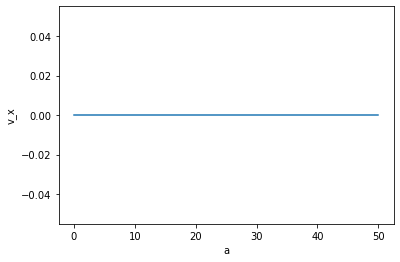

In [26]:
sols[1].dataset.data_vars['v_x'].plot(x='a')

In [27]:
sols[1].v_x({'a' : 8.333499999999999 - 8.12633439})

<xarray.DataArray 'v_x' ()>
array(0.)
Coordinates:
    a        float64 0.2072

RuntimeError: matplotlib does not support generators as input

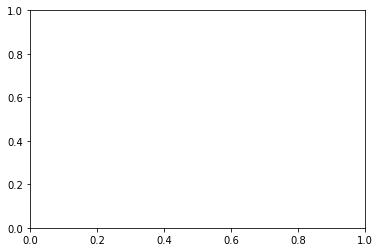

In [28]:
m = np.linspace(epsilon,50,25)

plt.plot(m, map(growth_v_y_terminal, m))

In [ ]:
sols[0].v_x({'a' : np.linspace(epsilon,50,25)})

We can then retrieve the solution object for the first stage, a consumption stage.

In [ ]:
sols[0]

We find that as expected, the optimal policy $\pi^*$ of the consumption stage is to consume all available resources.

In [ ]:
sols[0].dataset.data_vars['pi*'].plot(x='m')

Next, we can take the _input_ value function $v_x$ of this consumption stage, and use it as the final _output_ function for another round of backwards induction.

First, let's look at $v_x$. It is a close approximation of the reward function for the consumption stage.
This is expected!

In [ ]:
f = lambda c : consumption_stage.reward({},{}, {'c':c})
m = np.linspace(1,25,200)
plt.plot(m, f(m), label = 'R')
plt.plot(m, sols[0].v_x({'m' :m}), label = 'v_x')
plt.legend()
#sols[0].dataset.data_vars['v_x'].plot(x='m', ax = ax)

Now we can run backwards induction with the new (penultimate) value function:

In [ ]:
sols = backwards_induction(stages_data, sols[0].v_x)

Now we have a new consumption function!

It is not smooth because of the coarseness of the discretization grid.

In [ ]:
sols[0].dataset.data_vars['pi*'].plot(x='m')

#### Alternative Composition: splitting independent shocks

Above, we found that the growth stage had a very large grid because of the size of the shock space. One optimization we can do with generalized Bellman stages is break down the effects of each independent shock into a separate stage.


#### $\eta$ Risky growth

The growth stage stage:

* $A_2 = \emptyset$
* $(a, \alpha) \in X_2 = \mathbb{R}^2$
* $a_\eta \in Y_0 = \mathbb{R}$
* Shocks:
    * $\eta \sim \text{Lognormal}(0,\sigma_\eta)$
* $F_2(a,\alpha) = 0$
* $T_2(a,\alpha) =  \alpha \eta + (1 - \alpha) R$
* $\beta = L$

Requires parameter $R$.

#### $\theta$ Transitory Growth

* $A_2 = \emptyset$
* $a_\eta \in X_2 = \mathbb{R}$
* $a_\theta \in Y_0 = \mathbb{R}$
* Shocks:
    * $\theta \sim \text{Lognormal}(0,\sigma_\theta)$
* $F_2(a,\alpha) = 0$
* $T_2(a,\alpha) =  a_\eta + \theta$ 

#### $\psi$ Permanent growth

* $A_2 = \emptyset$
* $a_\theta \in X_2 = \mathbb{R}$
* $m \in Y_0 = \mathbb{R}$
* Shocks:
    * $\psi \sim \text{Lognormal}(0,\sigma_\psi)$
* $F_2(a,\alpha) = 0$
* $T_2(a,\alpha) =  \frac{a_\theta}{R\psi}$
* $\beta(\psi) = \psi^{1 - \rho}$ ??

In [ ]:
def risky_growth_transition(x, k, a): 
    return {'a_eta' : ((x['alpha'] * k['eta'] + (1 - x['alpha']) * R))}

risky_growth_stage = Stage(
    transition = growth_transition,
    inputs = ['a', 'alpha'],
    discount = lambda x, k, a: p_live, 
    shocks = {
        'eta' : distribution.Lognormal(0, sigma_eta),
        # 'live' : distribution.Bernoulli(p_live) ## Not implemented for now
    },
    outputs = ['a_eta'],
)

transitory_growth_stage = Stage(
    transition = lambda x, k, a : {'a_theta' : (x['a_eta'] + k['theta'])},
    inputs = ['a_eta'],
    shocks = {
        'theta' : distribution.Lognormal(0, sigma_theta),
        # 'live' : distribution.Bernoulli(p_live) ## Not implemented for now
    },
    outputs = ['a_theta'],
)

permanent_growth_stage = Stage(
    transition = lambda x, k, a : {'a_theta' : (x['a_theta'] / ( k['psi'] * G))},
    inputs = ['a_theta'],
    discount = lambda x, k, a: k['psi'] ** (1 - CRRA), 
    shocks = {
        'psi' : distribution.Lognormal(0, sigma_psi),
        # 'live' : distribution.Bernoulli(p_live) ## Not implemented for now
    },
    outputs = ['m'],
)